**about the data:**

The Brain Tumor dataset includes MRI scans of the human brain, labeled to indicate the presence or absence of tumors. It often contains three types of tumors: meningioma, glioma, and pituitary, or simply tumor vs. no tumor. The images can be in grayscale or RGB format depending on the version. This dataset is primarily used in medical imaging projects for tumor detection, classification, and segmentation.

##To run on your Drive:##
1. Open the link https://drive.google.com/drive/folders/1WDp9doYnxeKIel6-YnRzZ75z3gv1oos_?usp=sharing
2. Add a shortcut to MyDrive on your personal Drive
3. Run the notebook

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls  gdrive/MyDrive/Brain_Tumor

Mounted at /content/gdrive
ls: cannot access 'gdrive/MyDrive/Brain_Tumor': No such file or directory


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import shutil

# Define paths
source_dir = "/content/gdrive/MyDrive/Brain_Tumor/Training"  # Update with your actual path

# Output path: current directory
output_dir = "./brain_tumor_dataset"

# Number of images per class for each set
split_counts = {
    'Training': 80,
    'Validation': 40,
    'Testing': 40
}

# Target classes
classes = ["glioma_tumor", "meningioma_tumor"]

def is_image_file(filename):
    return filename.lower().endswith(('.jpg', '.jpeg', '.png'))

def prepare_split_data():
    # Create split folders
    for split in split_counts:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    for cls in classes:
        class_path = os.path.join(source_dir, cls)
        all_images = [f for f in os.listdir(class_path) if is_image_file(f)]
        random.shuffle(all_images)

        total_needed = sum(split_counts.values())
        selected_images = all_images[:total_needed]

        start = 0
        for split, count in split_counts.items():
            split_images = selected_images[start:start+count]
            for img in split_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(output_dir, split, cls, img)
                try:
                    shutil.copyfile(src, dst)
                except Exception as e:
                    print(f"⚠️ Skipping {img} due to error: {e}")
            start += count

    print("\n✅ Dataset split complete.")
    print(f"Split folders created inside: {os.path.abspath(output_dir)}")

# Run
prepare_split_data()


✅ Dataset split complete.
Split folders created inside: /content/brain_tumor_dataset


In [ ]:
%cd "/content/brain_tumor_dataset"

/content/brain_tumor_dataset


In [ ]:
!ls

Testing  Training  Validation


In [ ]:
!ls /content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor/Testing

glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor


Found 160 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Loaded 160 images.
Loaded 80 images.
Loaded 80 images.


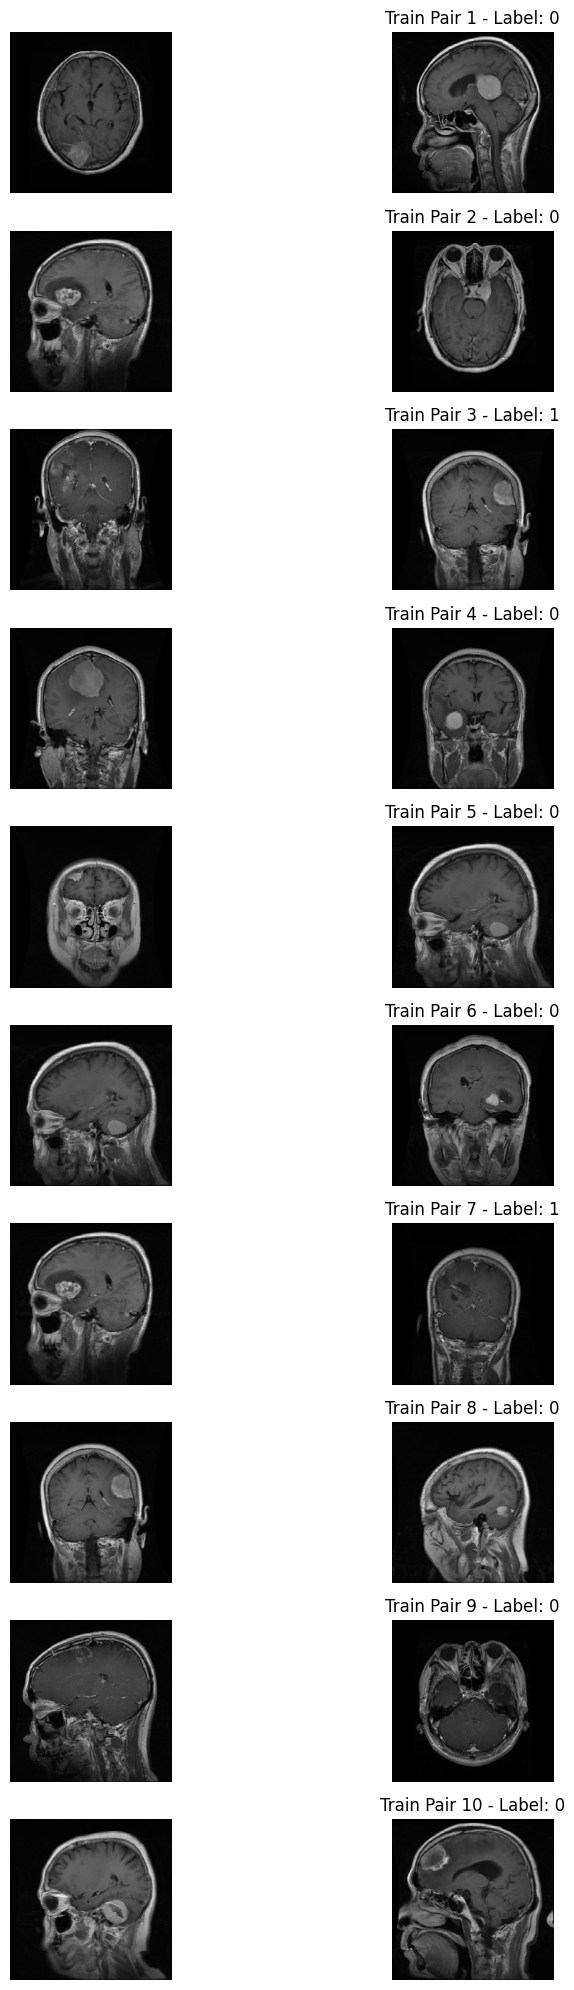

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class SiamesePairGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_generator, batch_size=32):
        self.batch_size = batch_size
        self.base_generator = base_generator
        self.x, self.y = self._load_data()
        self.label_to_indices = {label: np.where(self.y == label)[0] for label in np.unique(self.y)}

    def _load_data(self):
        x, y = [], []
        self.base_generator.reset()
        for _ in range(len(self.base_generator)):
            xi, yi = next(self.base_generator)
            x.append(xi)
            y.append(yi)
        x = np.concatenate(x)
        y = np.concatenate(y)
        print(f"Loaded {len(x)} images.")
        return x, y

    def __len__(self):
        return max(1, len(self.x) // self.batch_size)

    def __getitem__(self, idx):
        left, right, labels = [], [], []

        for _ in range(self.batch_size):
            if np.random.rand() < 0.5:
                cls = np.random.choice(list(self.label_to_indices.keys()))
                i1, i2 = np.random.choice(self.label_to_indices[cls], 2, replace=False)
                labels.append(0)
            else:
                cls1, cls2 = np.random.choice(list(self.label_to_indices.keys()), 2, replace=False)
                i1 = np.random.choice(self.label_to_indices[cls1])
                i2 = np.random.choice(self.label_to_indices[cls2])
                labels.append(1)
            left.append(self.x[i1])
            right.append(self.x[i2])

        return (np.array(left), np.array(right)), np.array(labels)

def visualize(p1, p2, labels, title):
    plt.figure(figsize=(10, 20))
    for i in range(10):
        plt.subplot(10, 2, 2*i+1)
        plt.imshow(p1[i]); plt.axis('off')
        plt.subplot(10, 2, 2*i+2)
        plt.imshow(p2[i]); plt.axis('off')
        plt.title(f'{title} Pair {i+1} - Label: {labels[i]}')
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    train_dir = './Training'  # <-- must have subfolders per class!
    val_dir = './Validation'
    test_dir = './Testing'

    datagen = ImageDataGenerator(rescale=1./255)
    img_size = (224, 224)

    base_train = datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=32, class_mode='binary', shuffle=True)
    base_val = datagen.flow_from_directory(
        val_dir, target_size=img_size, batch_size=32, class_mode='binary', shuffle=False)
    base_test = datagen.flow_from_directory(
        test_dir, target_size=img_size, batch_size=32, class_mode='binary', shuffle=False)

    train_gen = SiamesePairGenerator(base_train, batch_size=16)
    val_gen = SiamesePairGenerator(base_val, batch_size=16)
    test_gen= SiamesePairGenerator(base_test, batch_size=16)

    # Test: fetch first batch
    (x1, x2), y = train_gen[0]
    visualize(x1, x2, y, title='Train')

Loaded 160 images.
Loaded 40 images.


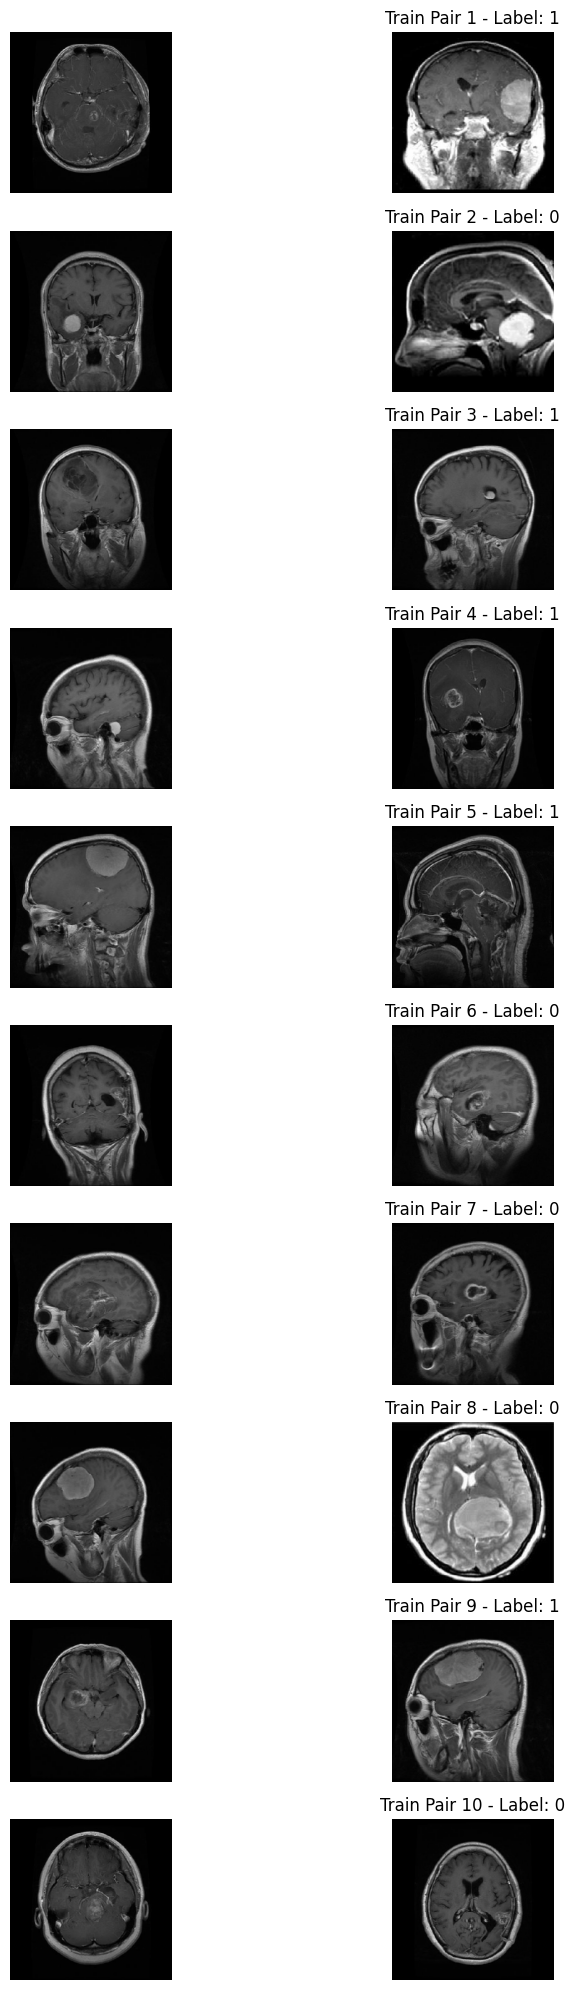

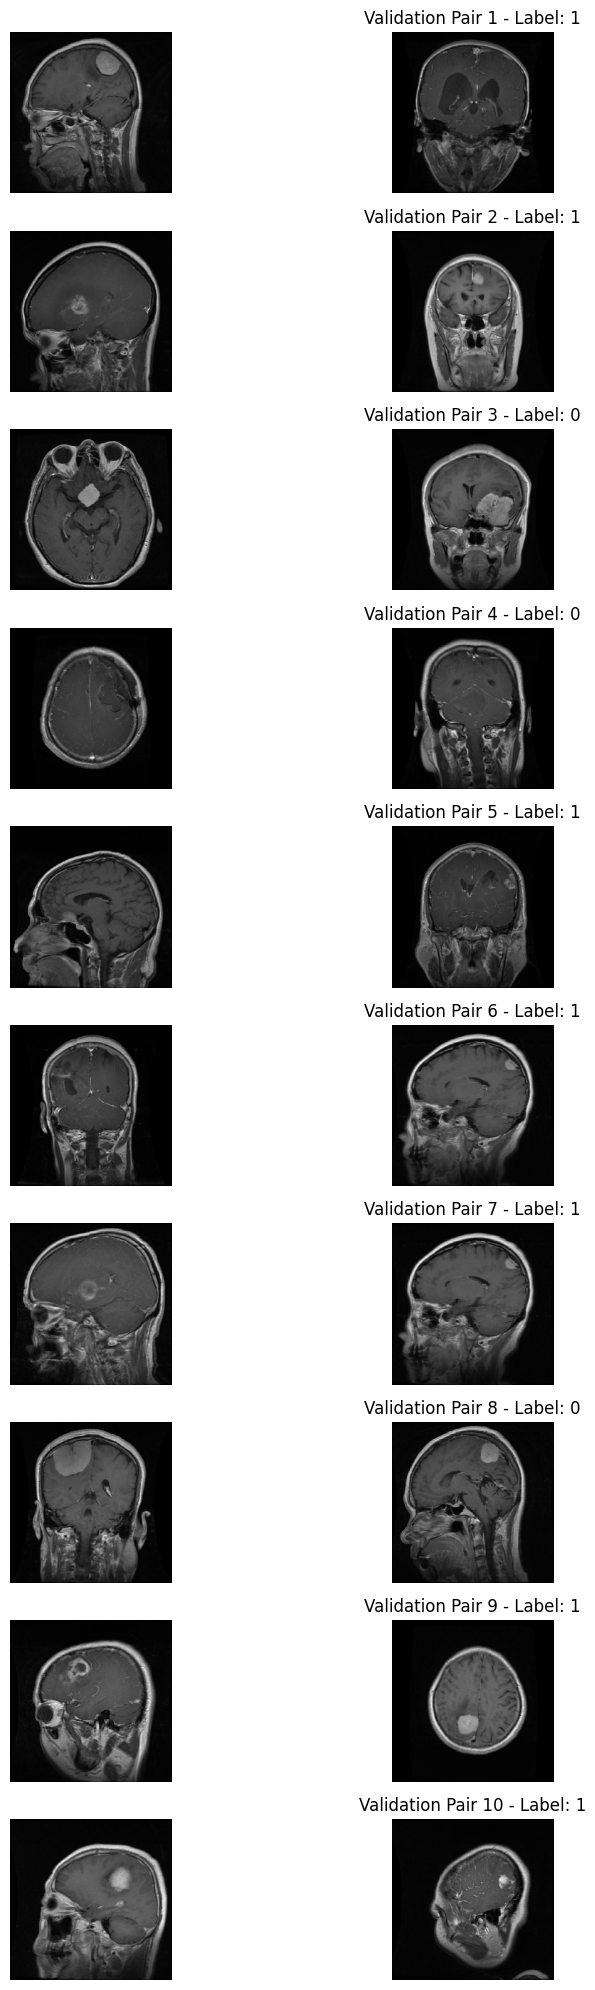

In [ ]:
train_gen = SiamesePairGenerator(base_train, batch_size=32)
val_gen = SiamesePairGenerator(base_val, batch_size=32)


    # Example usage: one batch
(train_left, train_right), train_labels = train_gen[0]
(val_left, val_right), val_labels = val_gen[0]

    # Visualize 10 training and validation pairs
visualize(train_left, train_right, train_labels, title='Train')
visualize(val_left, val_right, val_labels, title='Validation')

In [ ]:
# Define a Siamese network with DenseNet121 as the base model
def build_siamese_network(input_shape):
    # Load pre-trained DenseNet121 with ImageNet weights
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the pre-trained layers except for the last 20 layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Add custom layers on top of DenseNet121
    input = keras.layers.Input(input_shape)
    x = base_model(input)

    # Global pooling to reduce dimensions
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Additional dense layers for feature extraction
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    return keras.Model(input, x)

# Define contrastive loss function
def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return loss

# Euclidean Distance Function
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

def compute_contrastive_accuracy(y_true, y_pred, threshold=0.5):
    return tf.keras.metrics.binary_accuracy(y_true, tf.cast(y_pred > threshold, tf.float32))


# Create the Siamese model using DenseNet121
input_shape = (224, 224, 3)  # Standard input size for DenseNet121
embedding_network = build_siamese_network(input_shape)

input_1 = keras.layers.Input(input_shape)
input_2 = keras.layers.Input(input_shape)

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese_network = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

siamese_network.compile(loss=contrastive_loss(margin=1.5), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[compute_contrastive_accuracy])
siamese_network.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  7,630,016 │ input_layer_2[0]… │
│ (Functional)        │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,630,022 (29.11 MB)

 Trainable params: 958,660 (3.66 MB)

 Non-trainable params: 6,671,362 (25.45 MB)

In [ ]:
# Callback to log distances in the desired format
class DistanceLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_generator, num_batches=None):
        """
        Initialize with a validation generator instead of raw data

        Args:
            validation_generator: The validation data generator
            num_batches: Number of batches to use for validation (default: all)
        """
        super().__init__()
        self.validation_generator = validation_generator
        self.num_batches = num_batches if num_batches is not None else len(validation_generator)

    def on_epoch_end(self, epoch, logs=None):
        # Initialize arrays to store predictions and labels
        all_distances = []
        all_labels = []

        # Collect predictions from validation generator
        for i in range(min(self.num_batches, len(self.validation_generator))):
            # Get batch from generator
            (x1_batch, x2_batch), y_batch = self.validation_generator[i]

            # Get distances for this batch
            distances = self.model.predict([x1_batch, x2_batch], verbose=0)

            # Append to our collections
            all_distances.extend(distances)
            all_labels.extend(y_batch)

        # Convert to numpy arrays
        all_distances = np.array(all_distances).flatten()
        all_labels = np.array(all_labels)

        # Calculate metrics (remember: 0=same class, 1=different class)
        val_pos_dist = all_distances[all_labels == 0].mean()
        val_neg_dist = all_distances[all_labels == 1].mean()
        distance_gap = val_neg_dist - val_pos_dist

        # Print in the desired format
        print(f"Validation Set - Avg distance (same): {val_pos_dist:.4f}")
        print(f"Validation Set - Avg distance (diff): {val_neg_dist:.4f}")
        print(f"Distance gap: {distance_gap:.4f}")

        # Save metrics for later visualization
        if not hasattr(self, 'history'):
            self.history = {
                'val_pos_dist': [],
                'val_neg_dist': [],
                'distance_gap': []
            }

        self.history['val_pos_dist'].append(val_pos_dist)
        self.history['val_neg_dist'].append(val_neg_dist)
        self.history['distance_gap'].append(distance_gap)


# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import Callback

class EmbeddingVisualizer(Callback):
    """
    Callback to visualize the embedding space after each epoch using data from a generator.
    """
    def __init__(self, validation_generator, embedding_network, num_samples=100, class_names=None):
        """
        Initialize the visualizer with a validation generator.

        Args:
            validation_generator: SiamesePairGenerator to get validation samples from
            embedding_network: Model that extracts embeddings
            num_samples: Maximum number of samples to plot
            class_names: List of class names (from base_generator.class_indices)
        """
        super().__init__()
        self.validation_generator = validation_generator
        self.embedding_network = embedding_network
        self.num_samples = min(num_samples, len(validation_generator) * validation_generator.batch_size)
        self.class_names = class_names

        # For collecting history
        self.embeddings_history = []
        self.figures = []

        # Cache data for visualization
        self.cached_data = self._cache_data()

    def _cache_data(self):
        """Cache a subset of the validation data for visualization"""
        x1_samples, x2_samples, labels = [], [], []
        samples_collected = 0
        batch_index = 0

        # Collect samples until we reach desired number
        while samples_collected < self.num_samples and batch_index < len(self.validation_generator):
            # Get batch from generator
            (x1_batch, x2_batch), y_batch = self.validation_generator[batch_index]

            # Determine how many samples to take from this batch
            samples_to_take = min(len(y_batch), self.num_samples - samples_collected)

            # Add samples to our collections
            x1_samples.append(x1_batch[:samples_to_take])
            x2_samples.append(x2_batch[:samples_to_take])
            labels.append(y_batch[:samples_to_take])

            # Update counters
            samples_collected += samples_to_take
            batch_index += 1

        # Combine all batches
        x1_all = np.vstack(x1_samples)
        x2_all = np.vstack(x2_samples)
        labels_all = np.concatenate(labels)

        print(f"Cached {len(labels_all)} samples for embedding visualization")
        return x1_all, x2_all, labels_all

    def on_epoch_end(self, epoch, logs=None):
        # Get cached data
        x1_all, x2_all, labels_all = self.cached_data

        # Extract embeddings using the embedding network
        embeddings_1 = self.embedding_network.predict(x1_all, verbose=0)
        embeddings_2 = self.embedding_network.predict(x2_all, verbose=0)

        # Apply PCA to reduce dimensions for visualization
        combined = np.vstack([embeddings_1, embeddings_2])
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(combined)

        # Split back into pairs
        reduced_1 = reduced[:len(embeddings_1)]
        reduced_2 = reduced[len(embeddings_1):]

        # Store embeddings for later analysis
        self.embeddings_history.append((reduced_1, reduced_2))

        # Create figure
        fig = plt.figure(figsize=(10, 8))

        # Get indices of same/different pairs
        same_indices = np.where(labels_all == 0)[0]
        diff_indices = np.where(labels_all == 1)[0]

        # Draw lines for same-category pairs (green)
        max_lines = min(50, len(same_indices))
        for i in same_indices[:max_lines]:
            plt.plot([reduced_1[i, 0], reduced_2[i, 0]],
                    [reduced_1[i, 1], reduced_2[i, 1]],
                    'g-', alpha=0.3)

        # Draw lines for different-category pairs (red)
        max_lines = min(50, len(diff_indices))
        for i in diff_indices[:max_lines]:
            plt.plot([reduced_1[i, 0], reduced_2[i, 0]],
                    [reduced_1[i, 1], reduced_2[i, 1]],
                    'r-', alpha=0.3)

        # Plot the points
        plt.scatter(reduced_1[:, 0], reduced_1[:, 1], alpha=0.6, label='Image 1')
        plt.scatter(reduced_2[:, 0], reduced_2[:, 1], alpha=0.6, label='Image 2')

        # Add grid and labels
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title(f'Brain Tumor Embedding Space - Epoch {epoch+1}')
        plt.xlabel('Embedding Dimension 1')
        plt.ylabel('Embedding Dimension 2')

        # Add legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color='g', lw=2, label='Same Category'),
            Line2D([0], [0], color='r', lw=2, label='Different Category'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='C0', markersize=8, label='Image 1'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='C1', markersize=8, label='Image 2')
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        # Save figure
        self.figures.append(fig)

        # Display the plot
        plt.show()
        plt.close()

In [ ]:
gdrive_save_path = '/content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor/siamese_model_best.keras' # Changed to .keras
final_gdrive_save_path = '/content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor/siamese_model_final.keras' # Changed to .keras


import os
from tensorflow.keras.callbacks import EarlyStopping

gdrive_folder = os.path.dirname(gdrive_save_path)
os.makedirs(gdrive_folder, exist_ok=True)
print(f"Saving models to: {gdrive_folder}")


# Create the callbacks
distance_logger = DistanceLogger(validation_generator=val_gen)
embedding_visualizer = EmbeddingVisualizer(
    validation_generator=val_gen,
    embedding_network=embedding_network,  # This should be the base network that extracts embeddings
    num_samples=200,
    class_names=list(base_train.class_indices.keys())  # Get class names from the base generator
)

# Create your other callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=gdrive_save_path,  # Save to Google Drive
        save_best_only=True,
        monitor='val_loss',  # Monitor validation loss
        mode='min',          # Save when validation loss decreases
        verbose=1
    ),
    EarlyStopping(patience=5, restore_best_weights=True),
    distance_logger,
    embedding_visualizer
]


Saving models to: /content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor
Cached 80 samples for embedding visualization


Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - compute_contrastive_accuracy: 0.4947 - loss: 0.6545
Epoch 1: val_loss improved from inf to 0.58582, saving model to /content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor/siamese_model_best.keras
Validation Set - Avg distance (same): 0.6178
Validation Set - Avg distance (diff): 0.6240
Distance gap: 0.0062


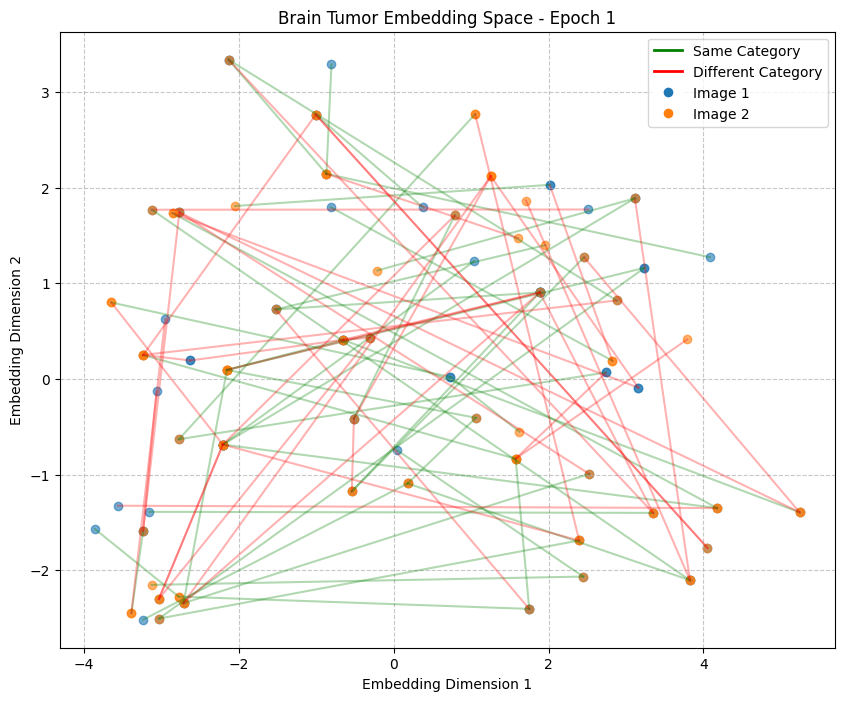

10/10 ━━━━━━━━━━━━━━━━━━━━ 150s 11s/step - compute_contrastive_accuracy: 0.4935 - loss: 0.6539 - val_compute_contrastive_accuracy: 0.5250 - val_loss: 0.5858
Epoch 2/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - compute_contrastive_accuracy: 0.6125 - loss: 0.5259
Epoch 2: val_loss improved from 0.58582 to 0.56933, saving model to /content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor/siamese_model_best.keras
Validation Set - Avg distance (same): 0.6057
Validation Set - Avg distance (diff): 0.6189
Distance gap: 0.0132


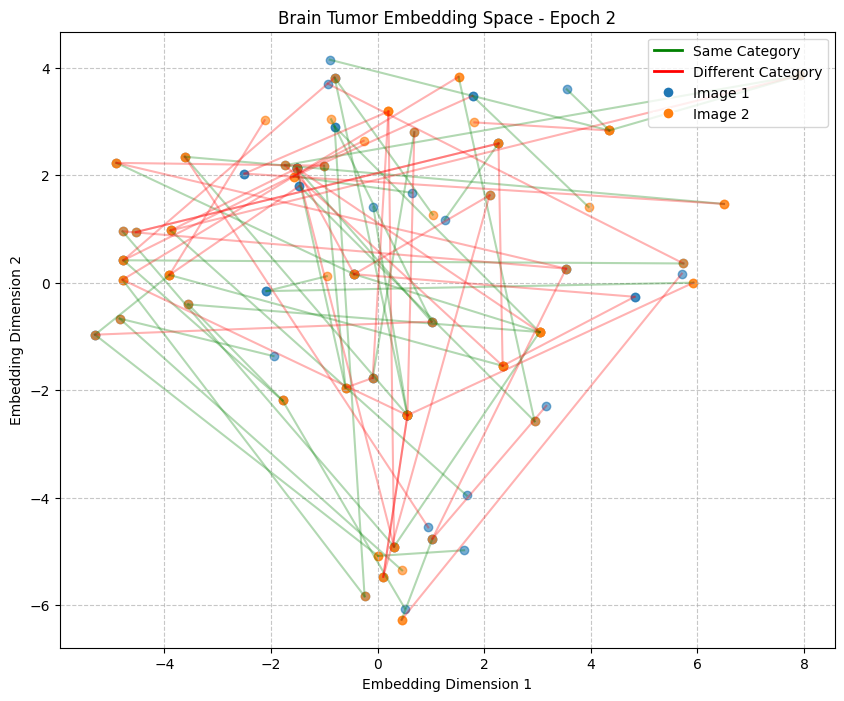

10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 579ms/step - compute_contrastive_accuracy: 0.6085 - loss: 0.5297 - val_compute_contrastive_accuracy: 0.5125 - val_loss: 0.5693
Epoch 3/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - compute_contrastive_accuracy: 0.6165 - loss: 0.5828
Epoch 3: val_loss did not improve from 0.56933
Validation Set - Avg distance (same): 0.6049
Validation Set - Avg distance (diff): 0.6243
Distance gap: 0.0195


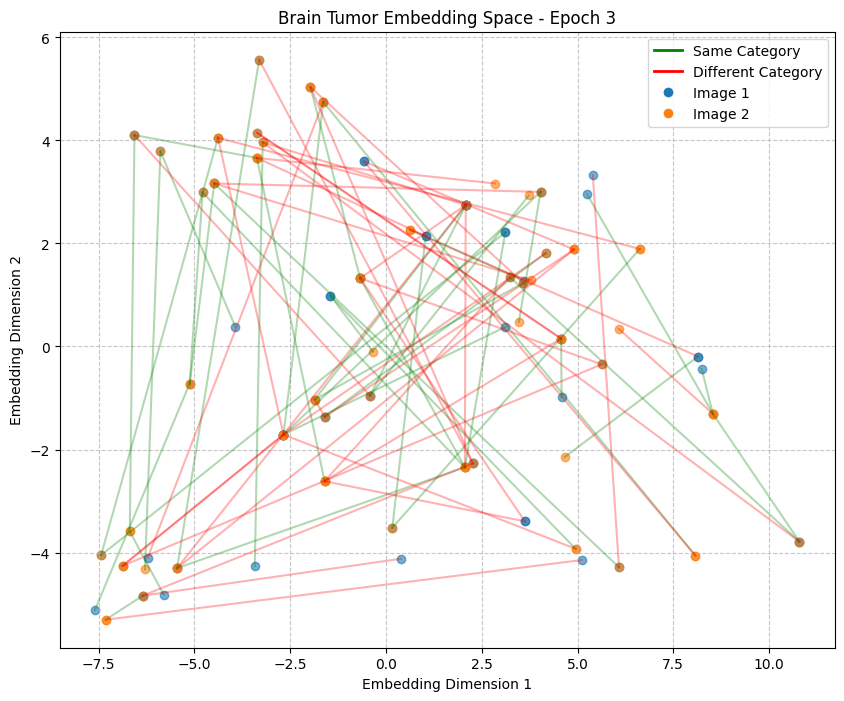

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 377ms/step - compute_contrastive_accuracy: 0.6161 - loss: 0.5843 - val_compute_contrastive_accuracy: 0.5375 - val_loss: 0.5835
Epoch 4/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - compute_contrastive_accuracy: 0.6491 - loss: 0.6212 
Epoch 4: val_loss did not improve from 0.56933
Validation Set - Avg distance (same): 0.5887
Validation Set - Avg distance (diff): 0.6374
Distance gap: 0.0487


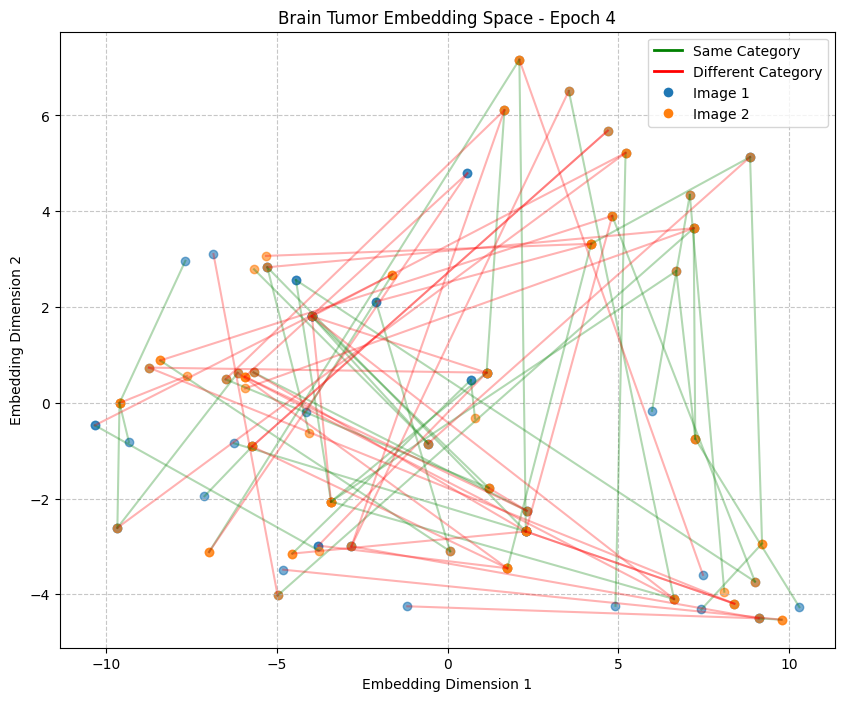

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step - compute_contrastive_accuracy: 0.6492 - loss: 0.6208 - val_compute_contrastive_accuracy: 0.5750 - val_loss: 0.5817
Epoch 5/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - compute_contrastive_accuracy: 0.7249 - loss: 0.6040
Epoch 5: val_loss did not improve from 0.56933
Validation Set - Avg distance (same): 0.5694
Validation Set - Avg distance (diff): 0.6154
Distance gap: 0.0460


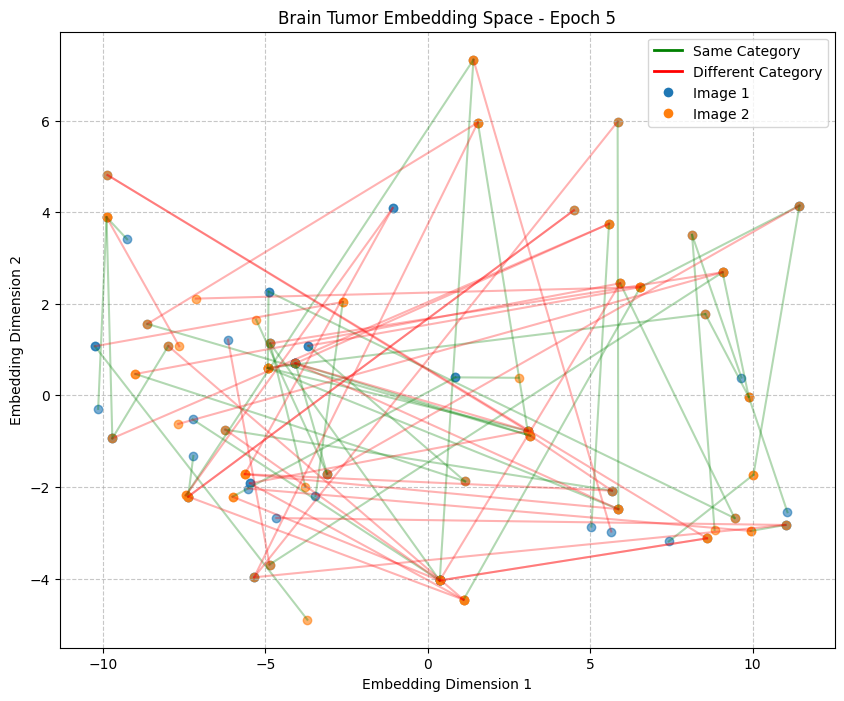

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 379ms/step - compute_contrastive_accuracy: 0.7215 - loss: 0.6047 - val_compute_contrastive_accuracy: 0.5750 - val_loss: 0.5991
Epoch 6/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - compute_contrastive_accuracy: 0.6411 - loss: 0.6755
Epoch 6: val_loss improved from 0.56933 to 0.56431, saving model to /content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor/siamese_model_best.keras
Validation Set - Avg distance (same): 0.5806
Validation Set - Avg distance (diff): 0.6350
Distance gap: 0.0544


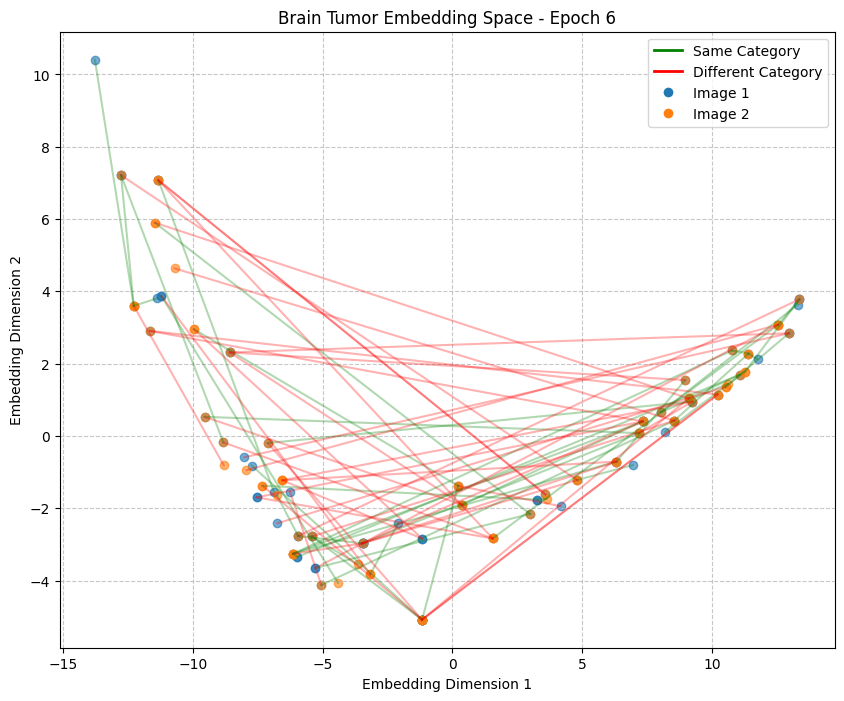

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 583ms/step - compute_contrastive_accuracy: 0.6430 - loss: 0.6719 - val_compute_contrastive_accuracy: 0.5375 - val_loss: 0.5643
Epoch 7/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - compute_contrastive_accuracy: 0.8044 - loss: 0.5942
Epoch 7: val_loss did not improve from 0.56431
Validation Set - Avg distance (same): 0.5757
Validation Set - Avg distance (diff): 0.6398
Distance gap: 0.0641


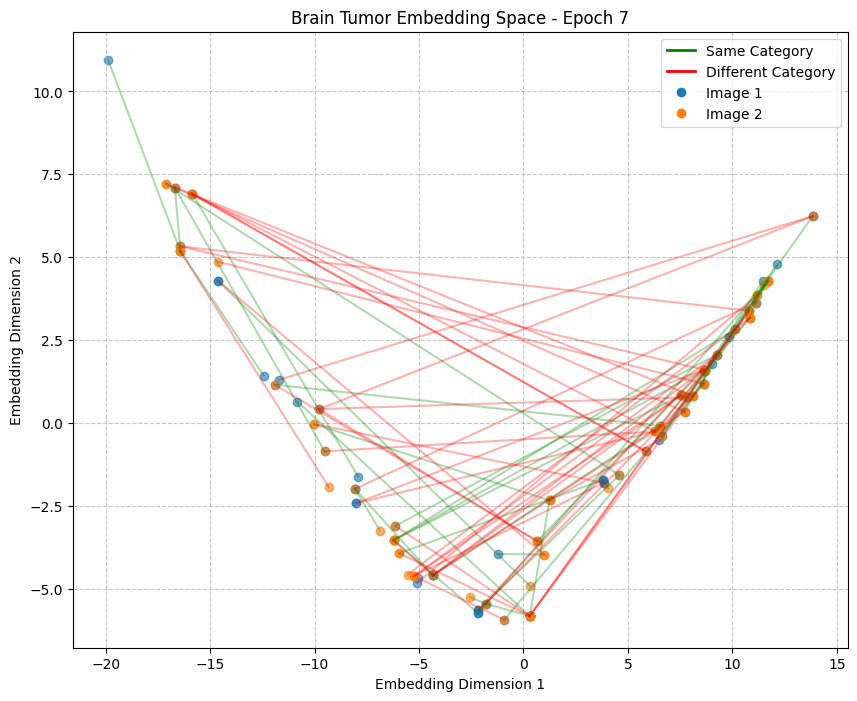

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 378ms/step - compute_contrastive_accuracy: 0.8012 - loss: 0.5939 - val_compute_contrastive_accuracy: 0.6375 - val_loss: 0.5905
Epoch 8/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - compute_contrastive_accuracy: 0.7079 - loss: 0.6086
Epoch 8: val_loss improved from 0.56431 to 0.51218, saving model to /content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor/siamese_model_best.keras
Validation Set - Avg distance (same): 0.5789
Validation Set - Avg distance (diff): 0.6838
Distance gap: 0.1050


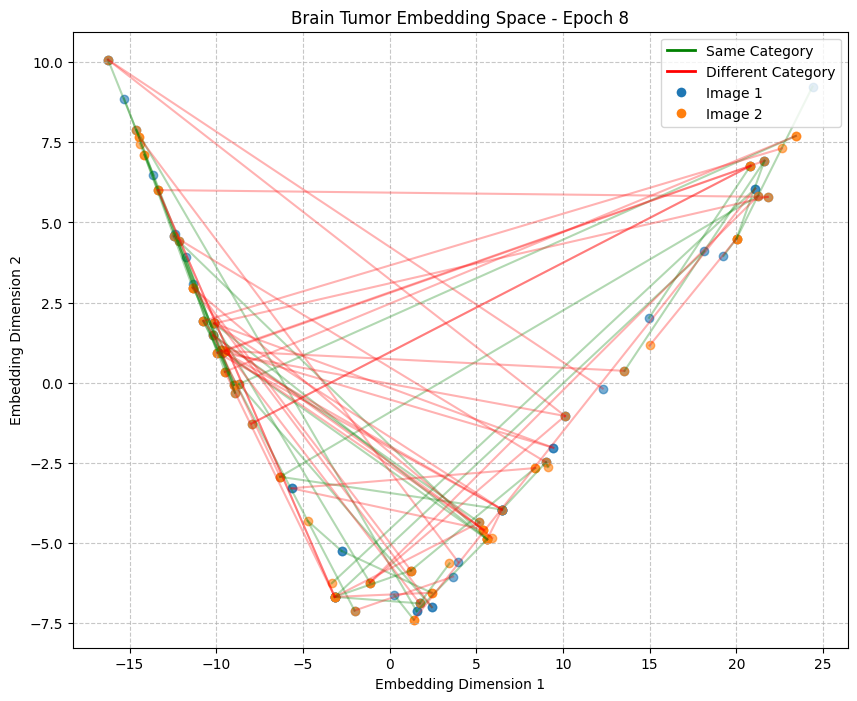

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 534ms/step - compute_contrastive_accuracy: 0.7111 - loss: 0.6093 - val_compute_contrastive_accuracy: 0.5000 - val_loss: 0.5122
Epoch 9/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - compute_contrastive_accuracy: 0.7978 - loss: 0.5506
Epoch 9: val_loss improved from 0.51218 to 0.48912, saving model to /content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor/siamese_model_best.keras
Validation Set - Avg distance (same): 0.5894
Validation Set - Avg distance (diff): 0.6772
Distance gap: 0.0878


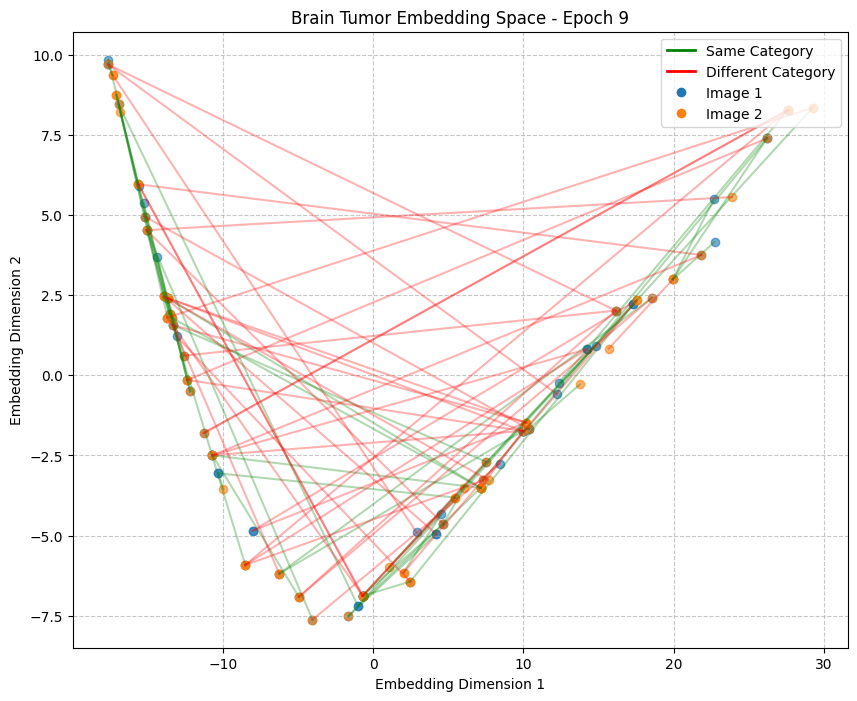

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 644ms/step - compute_contrastive_accuracy: 0.7963 - loss: 0.5498 - val_compute_contrastive_accuracy: 0.5875 - val_loss: 0.4891
Epoch 10/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - compute_contrastive_accuracy: 0.8726 - loss: 0.5668
Epoch 10: val_loss did not improve from 0.48912
Validation Set - Avg distance (same): 0.5486
Validation Set - Avg distance (diff): 0.6270
Distance gap: 0.0784


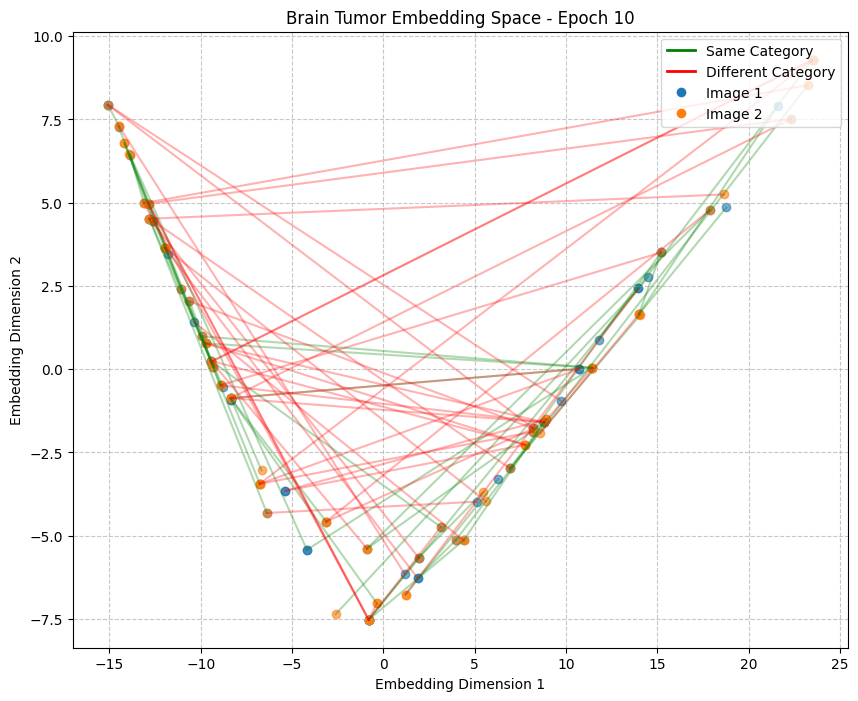

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - compute_contrastive_accuracy: 0.8705 - loss: 0.5695 - val_compute_contrastive_accuracy: 0.6125 - val_loss: 0.5326
Epoch 11/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - compute_contrastive_accuracy: 0.8672 - loss: 0.5560 
Epoch 11: val_loss did not improve from 0.48912
Validation Set - Avg distance (same): 0.5429
Validation Set - Avg distance (diff): 0.6259
Distance gap: 0.0830


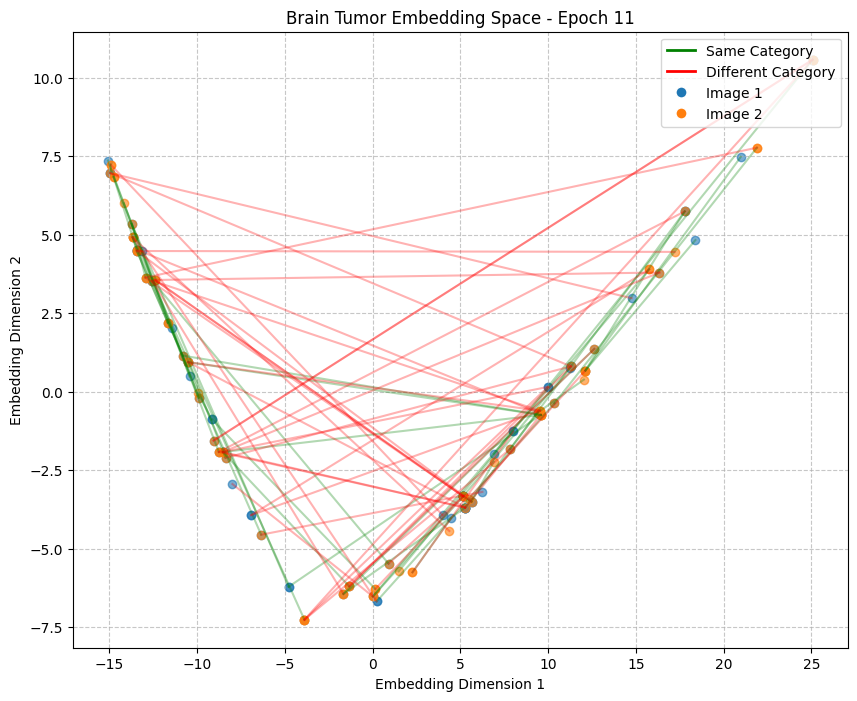

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 428ms/step - compute_contrastive_accuracy: 0.8679 - loss: 0.5556 - val_compute_contrastive_accuracy: 0.7250 - val_loss: 0.5399
Epoch 12/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - compute_contrastive_accuracy: 0.9594 - loss: 0.6089
Epoch 12: val_loss did not improve from 0.48912
Validation Set - Avg distance (same): 0.5355
Validation Set - Avg distance (diff): 0.6384
Distance gap: 0.1029


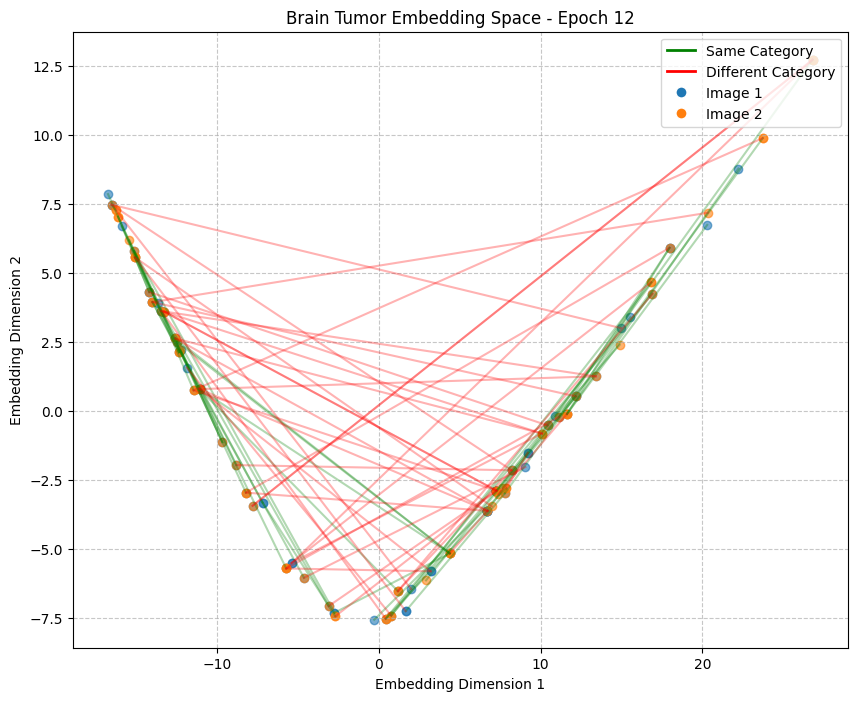

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - compute_contrastive_accuracy: 0.9574 - loss: 0.6047 - val_compute_contrastive_accuracy: 0.6500 - val_loss: 0.5015
Epoch 13/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - compute_contrastive_accuracy: 0.8393 - loss: 0.5760
Epoch 13: val_loss did not improve from 0.48912
Validation Set - Avg distance (same): 0.5493
Validation Set - Avg distance (diff): 0.6310
Distance gap: 0.0817


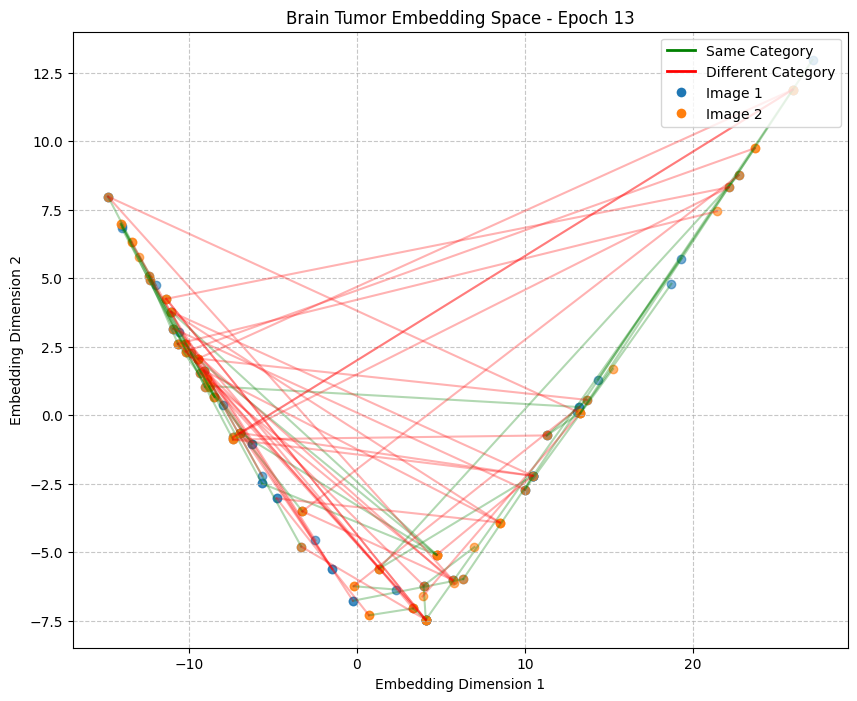

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - compute_contrastive_accuracy: 0.8442 - loss: 0.5772 - val_compute_contrastive_accuracy: 0.7000 - val_loss: 0.5174
Epoch 14/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - compute_contrastive_accuracy: 0.8751 - loss: 0.5069
Epoch 14: val_loss did not improve from 0.48912
Validation Set - Avg distance (same): 0.5478
Validation Set - Avg distance (diff): 0.6646
Distance gap: 0.1168


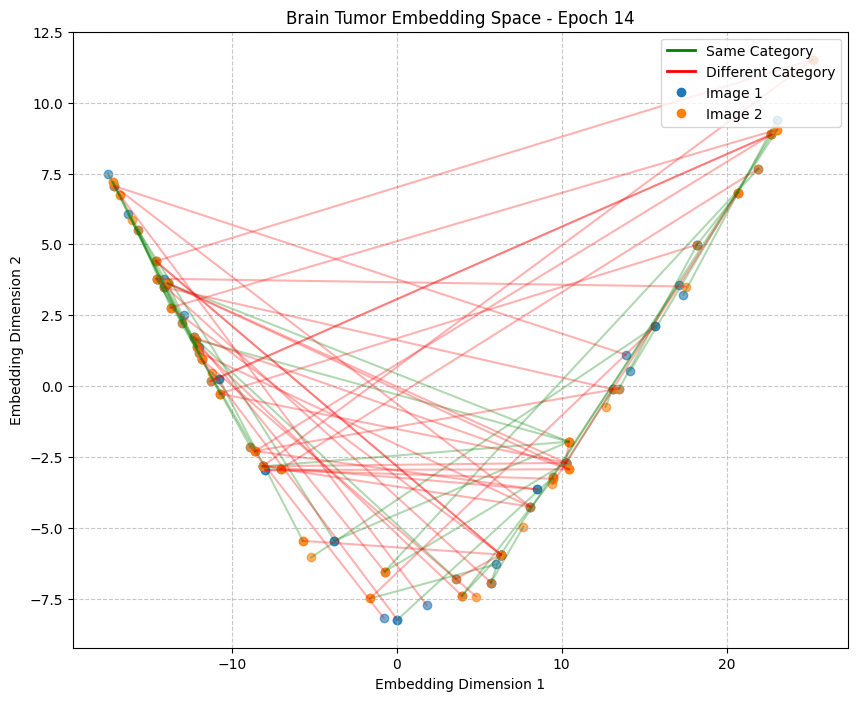

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - compute_contrastive_accuracy: 0.8768 - loss: 0.5104 - val_compute_contrastive_accuracy: 0.7375 - val_loss: 0.5568


In [ ]:
# Train the model
history = siamese_network.fit(
    train_gen,
    epochs=80,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)


In [ ]:
siamese_network.save(final_gdrive_save_path)
print(f"Final Siamese model saved to: {final_gdrive_save_path}")

Final Siamese model saved to: /content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor/siamese_model_final.keras


results on test

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import seaborn as sns


def evaluate_siamese_performance(model, data_generator, threshold=0.5):
    """Comprehensive evaluation of Siamese network performance"""
    # Get all distances and labels
    all_distances = []
    all_labels = []

    for i in range(len(data_generator)):
        (images_a, images_b), labels = data_generator[i]
        distances = model.predict([images_a, images_b], verbose=0).flatten()
        all_distances.extend(distances)
        all_labels.extend(labels)

    all_distances = np.array(all_distances)
    all_labels = np.array(all_labels)

    # Get similar and dissimilar distances
    similar_distances = all_distances[all_labels == 0]
    dissimilar_distances = all_distances[all_labels == 1]

    # Calculate basic statistics
    similar_mean = np.mean(similar_distances)
    similar_std = np.std(similar_distances)
    dissimilar_mean = np.mean(dissimilar_distances)
    dissimilar_std = np.std(dissimilar_distances)

    # Calculate ROC and PR curves
    fpr, tpr, thresholds_roc = roc_curve(all_labels, all_distances)
    roc_auc = auc(fpr, tpr)

    precision, recall, thresholds_pr = precision_recall_curve(all_labels, all_distances)
    pr_auc = average_precision_score(all_labels, all_distances)

    # Find optimal threshold using Youden's J statistic (maximizes tpr - fpr)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    optimal_threshold = thresholds_roc[best_idx]

    # Calculate predictions and accuracy with optimal threshold
    predictions = (all_distances > optimal_threshold).astype(int)
    accuracy = np.mean(predictions == all_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, predictions)

    results = {
        'similar_mean': similar_mean,
        'similar_std': similar_std,
        'dissimilar_mean': dissimilar_mean,
        'dissimilar_std': dissimilar_std,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'optimal_threshold': optimal_threshold,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'precision': precision,
        'recall': recall,
        'all_distances': all_distances,
        'all_labels': all_labels
    }

    return results

    # Evaluate on test set using the optimal threshold
print("\n--- Test Set Evaluation ---")
test_results = evaluate_siamese_performance(siamese_network, test_gen)

print(f"Test Results:")
print(f"Similar pairs - mean: {test_results['similar_mean']:.4f}, std: {test_results['similar_std']:.4f}")
print(f"Dissimilar pairs - mean: {test_results['dissimilar_mean']:.4f}, std: {test_results['dissimilar_std']:.4f}")
print(f"ROC AUC: {test_results['roc_auc']:.4f}")
print(f"PR AUC: {test_results['pr_auc']:.4f}")
print(f"Accuracy with optimal threshold: {test_results['accuracy']:.4f}")

# Enhanced visualization of results
plt.figure(figsize=(20, 15))



--- Test Set Evaluation ---
Test Results:
Similar pairs - mean: 0.5805, std: 0.1288
Dissimilar pairs - mean: 0.8289, std: 0.1718
ROC AUC: 0.8664
PR AUC: 0.8811
Accuracy with optimal threshold: 0.8438


<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

# CNN vs SNN

training CNN

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential

# === Define dataset path ===
data_dir = "/content/brain_tumor_dataset"
img_size = (224, 224)
batch_size = 16

# === Data augmentation and preprocessing ===
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Training'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Validation'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Testing'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# === Build CNN model with DenseNet121 backbone ===
def build_model(input_shape=(224, 224, 3)):
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze כל השכבות מלבד 20 האחרונות
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    input = Input(shape=input_shape)
    x = base_model(input, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.53)(x)
    x = layers.Dense(128, activation="relu")(x)
    output = layers.Dense(1, activation="sigmoid")(x)  # פלט בינארי

    model = Model(input, output)
    model.compile(
        optimizer=Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model(input_shape=(224, 224, 3))
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# === Train model ===
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=80,
    callbacks=callbacks)


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4560 - loss: 0.9096

10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.4595 - loss: 0.9126 - val_accuracy: 0.4750 - val_loss: 0.7283
Epoch 2/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5938 - loss: 0.8056

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5949 - loss: 0.7969 - val_accuracy: 0.6000 - val_loss: 0.6722
Epoch 3/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7505 - loss: 0.5356

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.7516 - loss: 0.5326 - val_accuracy: 0.6500 - val_loss: 0.6244
Epoch 4/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7113 - loss: 0.4839

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.7114 - loss: 0.4851 - val_accuracy: 0.6500 - val_loss: 0.5888
Epoch 5/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7706 - loss: 0.4977

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.7725 - loss: 0.4928 - val_accuracy: 0.7000 - val_loss: 0.5514
Epoch 6/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8707 - loss: 0.3279

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.8711 - loss: 0.3286 - val_accuracy: 0.7000 - val_loss: 0.5256
Epoch 7/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8003 - loss: 0.4364

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.8042 - loss: 0.4286 - val_accuracy: 0.6750 - val_loss: 0.5035
Epoch 8/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8608 - loss: 0.3215

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.8588 - loss: 0.3181 - val_accuracy: 0.7250 - val_loss: 0.4717
Epoch 9/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8913 - loss: 0.2612

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.8938 - loss: 0.2587 - val_accuracy: 0.7500 - val_loss: 0.4448
Epoch 10/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8872 - loss: 0.2578

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.8889 - loss: 0.2562 - val_accuracy: 0.7500 - val_loss: 0.4259
Epoch 11/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9448 - loss: 0.1755

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.9418 - loss: 0.1802 - val_accuracy: 0.7500 - val_loss: 0.4043
Epoch 12/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9616 - loss: 0.1675

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.9550 - loss: 0.1730 - val_accuracy: 0.7750 - val_loss: 0.3839
Epoch 13/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9613 - loss: 0.1473

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.9615 - loss: 0.1489 - val_accuracy: 0.8000 - val_loss: 0.3676
Epoch 14/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9824 - loss: 0.1426

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.9801 - loss: 0.1441 - val_accuracy: 0.8250 - val_loss: 0.3485
Epoch 15/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9994 - loss: 0.1111

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.9989 - loss: 0.1111 - val_accuracy: 0.8000 - val_loss: 0.3328
Epoch 16/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9614 - loss: 0.1210

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9615 - loss: 0.1218 - val_accuracy: 0.8500 - val_loss: 0.3117
Epoch 17/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9684 - loss: 0.0946

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.9685 - loss: 0.0968 - val_accuracy: 0.8500 - val_loss: 0.2940
Epoch 18/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9683 - loss: 0.1262

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - accuracy: 0.9695 - loss: 0.1253 - val_accuracy: 0.8750 - val_loss: 0.2822
Epoch 19/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9752 - loss: 0.1245

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.9751 - loss: 0.1223 - val_accuracy: 0.8750 - val_loss: 0.2789
Epoch 20/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9515 - loss: 0.0987

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9547 - loss: 0.0969 - val_accuracy: 0.8750 - val_loss: 0.2703
Epoch 21/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9751 - loss: 0.1107

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.9751 - loss: 0.1084 - val_accuracy: 0.8750 - val_loss: 0.2605
Epoch 22/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9992 - loss: 0.0755

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.9982 - loss: 0.0740 - val_accuracy: 0.8750 - val_loss: 0.2543
Epoch 23/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9957 - loss: 0.0590

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.9949 - loss: 0.0594 - val_accuracy: 0.8750 - val_loss: 0.2510
Epoch 24/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9804 - loss: 0.0996

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.9828 - loss: 0.0942 - val_accuracy: 0.8750 - val_loss: 0.2463
Epoch 25/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9960 - loss: 0.0710

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9958 - loss: 0.0698 - val_accuracy: 0.8750 - val_loss: 0.2391
Epoch 26/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0550

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 1.0000 - loss: 0.0553 - val_accuracy: 0.8750 - val_loss: 0.2301
Epoch 27/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0475

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 1.0000 - loss: 0.0479 - val_accuracy: 0.8750 - val_loss: 0.2255
Epoch 28/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0397

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 1.0000 - loss: 0.0398 - val_accuracy: 0.8750 - val_loss: 0.2233
Epoch 29/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0481

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 1.0000 - loss: 0.0465 - val_accuracy: 0.8750 - val_loss: 0.2228
Epoch 30/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9949 - loss: 0.0445

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - accuracy: 0.9942 - loss: 0.0460 - val_accuracy: 0.8750 - val_loss: 0.2218
Epoch 31/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9970 - loss: 0.0532

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.9967 - loss: 0.0523 - val_accuracy: 0.8750 - val_loss: 0.2181
Epoch 32/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0334

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 1.0000 - loss: 0.0341 - val_accuracy: 0.8750 - val_loss: 0.2132
Epoch 33/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0339

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 1.0000 - loss: 0.0339 - val_accuracy: 0.9000 - val_loss: 0.2081
Epoch 34/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0209

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 1.0000 - loss: 0.0210 - val_accuracy: 0.9000 - val_loss: 0.2063
Epoch 35/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0150

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 0.9000 - val_loss: 0.2047
Epoch 36/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9932 - loss: 0.0324

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9932 - loss: 0.0320 - val_accuracy: 0.9000 - val_loss: 0.2022
Epoch 37/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.0253 - val_accuracy: 0.9000 - val_loss: 0.2033
Epoch 38/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0266 - val_accuracy: 0.9250 - val_loss: 0.2070
Epoch 39/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 0.9250 - val_loss: 0.2093
Epoch 40/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 1.0000 - loss: 0.0176 - val_accuracy: 0.9250 - val_loss: 0.2103
Epoch 41/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 1.0000 - loss: 0.0183 - val_accuracy: 0.9250 - val_loss: 0.2100


ROC AUC: 0.9150
PR AUC: 0.9162
Optimal Threshold: 0.3505
Accuracy: 0.8250
Confusion Matrix:
[[16  4]
 [ 3 17]]


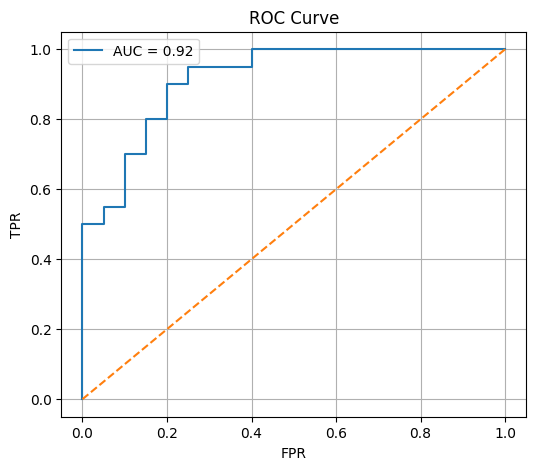

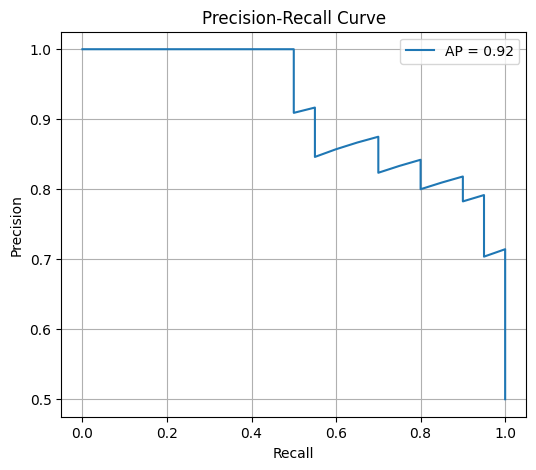

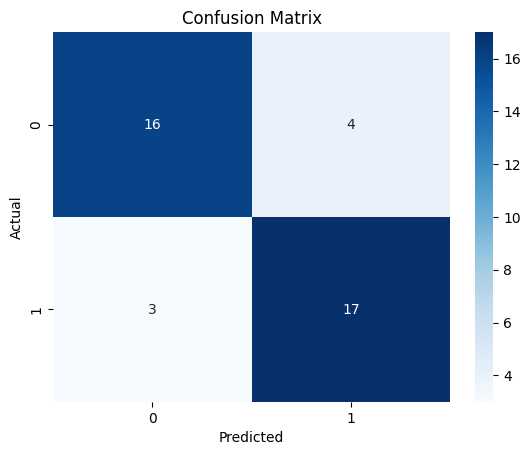

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_binary_model(model, data_gen):
    y_true = []
    y_scores = []

    for batch_x, batch_y in data_gen:
        preds = model.predict(batch_x, verbose=0).flatten()
        y_scores.extend(preds)
        y_true.extend(batch_y)
        if len(y_true) >= data_gen.samples:
            break

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
    pr_auc = average_precision_score(y_true, y_scores)

    # סף אופטימלי
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    optimal_threshold = thresholds_roc[best_idx]

    y_pred = (y_scores > optimal_threshold).astype(int)
    acc = np.mean(y_pred == y_true)
    cm = confusion_matrix(y_true, y_pred)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # ROC
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # PR
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f"AP = {pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid()
    plt.legend()
    plt.show()

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_binary_model(model, test_gen)
